In [1]:
import os, glob
import xarray
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from IPython.display import Image

In [3]:
import matplotlib.dates as mdates

In [4]:
fs=16
plt.rc("font",size=fs)

In [5]:
figPath = "/glade/u/home/doubrawa/figs/"

In [6]:
inPath = "/glade/scratch/doubrawa/post_processing/"

In [7]:
colors_days = {20:'#ABB2B9',
               21:'#5DADE2',
               28:'#16A085',
               29:'#D4AC0D',
               30:'#A569BD'}

In [8]:
days = [20,21,28,29,30]

# i/o

In [9]:
days = [20,21,28,29,30]

zis = {}
Ls  = {}

for day in days:
    filename = glob.glob(os.path.join(inPath,"PBLH_SPATIAL*March{0}*".format(day)))[0]
    print(filename)
    zi = pd.read_csv(filename,index_col=[0],parse_dates=True)
    zis[day] = (zi["median"]).copy()
    
    filename = glob.glob(os.path.join(inPath,"L_SPATIAL*March{0}*".format(day)))[0]
    print(filename)
    L = pd.read_csv(filename,index_col=[0],parse_dates=True,header=None)
    Ls[day] = L.copy()

/glade/scratch/doubrawa/post_processing/PBLH_SPATIAL_AVG_15km_by_15km_D02_March20.csv
/glade/scratch/doubrawa/post_processing/L_SPATIAL_AVG_15km_by_15km_D02_March20.csv
/glade/scratch/doubrawa/post_processing/PBLH_SPATIAL_AVG_15km_by_15km_D02_March21.csv
/glade/scratch/doubrawa/post_processing/L_SPATIAL_AVG_15km_by_15km_D02_March21.csv
/glade/scratch/doubrawa/post_processing/PBLH_SPATIAL_AVG_15km_by_15km_D02_March28.csv
/glade/scratch/doubrawa/post_processing/L_SPATIAL_AVG_15km_by_15km_D02_March28.csv
/glade/scratch/doubrawa/post_processing/PBLH_SPATIAL_AVG_15km_by_15km_D02_March29.csv
/glade/scratch/doubrawa/post_processing/L_SPATIAL_AVG_15km_by_15km_D02_March29.csv
/glade/scratch/doubrawa/post_processing/PBLH_SPATIAL_AVG_15km_by_15km_D02_March30.csv
/glade/scratch/doubrawa/post_processing/L_SPATIAL_AVG_15km_by_15km_D02_March30.csv


# instab param

In [10]:
params = {}

In [11]:
for day in days:
    params[day] = pd.Series(index=zis[day].index,data=(-zis[day].values/np.squeeze(Ls[day].values)))

# divide into categories...?

269
31


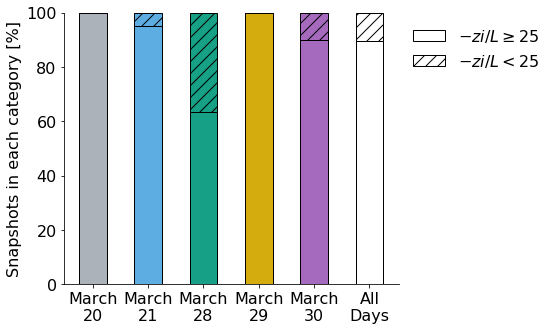

In [12]:
cutoff = 25

fig = plt.figure(figsize=(6,5))
ax  = fig.add_subplot(111)

i = 0

ncell_tot = 0
nnot_tot  = 0
nnorm     = 0

for day in days:
    
    param_day  = np.squeeze(params[day].values)
    param_cell = param_day[param_day>=cutoff]
    param_not  = param_day[param_day<cutoff]  
    
    ncell_tot  += len(param_cell)
    nnot_tot   += len(param_not)
    nnorm      += len(param_day)
    
    ncell = len(param_cell) / float(len(param_day)) * 100
    nnot  = len(param_not ) / float(len(param_day)) * 100
    
    ax.bar(x=i, height=ncell, width=0.5, color=colors_days[day], edgecolor='k')
    ax.bar(x=i, height=nnot, bottom=ncell, width=0.5, color=colors_days[day], edgecolor='k', hatch='//')    

    i+=1

print(ncell_tot)
print(nnot_tot)
    
ncell_tot = ncell_tot / float(nnorm) * 100
nnot_tot  = nnot_tot / float(nnorm) * 100

ax.bar(x=i, height=ncell_tot, width=0.5, color='w', edgecolor='k',label="$-zi/L\geq{0}$".format(cutoff)) 
ax.bar(x=i, height=nnot_tot, bottom=ncell_tot, width=0.5, color='w', edgecolor='k', hatch='//',label="$-zi/L<{0}$".format(cutoff))    
    
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(["March\n{0}".format(day) for day in days]+['All\nDays'])

ax.set_ylabel("Snapshots in each category [%]")

plt.legend(bbox_to_anchor=(1,1), frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# fig.savefig("/glade/u/home/doubrawa/figs/ziL_percentages_per_day.png",dpi=300,
#            bbox_inches="tight")

In [20]:
zil_alldays = os.path.join(inPath,"ziL_all_days.csv")
pd.concat([params[20],params[21],params[28],params[29],params[30]]).sort_index().to_csv(zil_alldays)

# save datetimes of convective snapshots

In [71]:
datetimes = []
for day in days:    
    indices = params[day][params[day]>=25].index.values
    for idx in indices:
        datetimes.append(idx)

In [74]:
pd.Series(datetimes).to_csv(os.path.join(inPath,"datetimes_ziL_gt_25.csv"))

## some params

In [50]:
# how wide of a square box should we consider when averaging zi in space? [km]
extent_of_interest_km = 15
# spatial resolution of domain output in x/y [km]
dx_km = 0.025
# which grid points does that correspond to?
extent_of_interest_npts = int(np.round(extent_of_interest_km/dx_km))

# plot

In [52]:
start = pd.Timestamp('20180606')

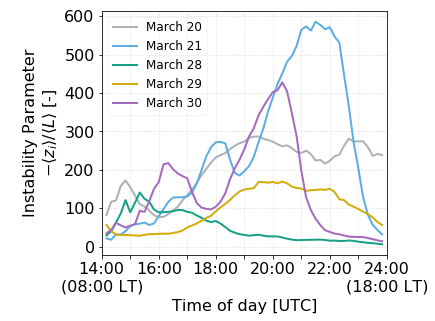

In [57]:
fig = plt.figure(figsize=(6,5))
ax  = fig.add_subplot(111)

iday = 0
for day in days:
        
    series = params[day].loc["2015-03-{0}".format(day)]    
    deltas = series.index-series.index[0]+pd.Timedelta('14h')
    index  = start+deltas
    
    ax.plot(index[1:],
            series.values[1:],color=colors_days[day],linestyle='-',lw=2,
            marker='None',label='March {0}'.format(day))

xticks = index[0::6]
xticks = xticks.append(pd.DatetimeIndex([start+pd.Timedelta('24h')]))
ax.set_xticks(xticks)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xticklabels(["14:00\n(08:00 LT)","","16:00","","18:00","","20:00","","22:00","","24:00\n(18:00 LT)"])
ax.set_xlim([xticks[0],xticks[-1]])
ax.set_xlabel("Time of day [UTC]")

ax.grid(color='lightgray',linestyle=':')

ax.set_ylabel("\nInstability Parameter\n"+r"$-\langle z_i \rangle / \langle L \rangle$ [-]")

lg = plt.legend(ncol=1,fontsize=12,framealpha=0.2)
fig.subplots_adjust(left=0.22,bottom=0.2,right=0.88)

fig.savefig("/glade/u/home/doubrawa/figs/zil_diurnal_cycles.png",dpi=300)

In [45]:
# Image("/glade/u/home/doubrawa/figs/ust_diurnal_cycles.png")